# Transfer learning / fine-tuning
---

This tutorial will guide you through the process of using transfer learning to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from ILSVRC), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

## Feature extraction vs. fine-tuning
At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

Sometimes, we do something in-between: Freeze just the early/generic layers, but fine-tune the later layers. Which strategy is best depends on the size of your dataset, the number of classes, and how much it resembles the dataset the previous model was trained on (and thus, whether it can benefit from the same learned feature extractors). A more detailed discussion of how to strategize can be found in [[1]](https://cs231n.github.io/transfer-learning/) and [[2]](https://sebastianruder.com/transfer-learning/).

Procedure
In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, VGG16 which won the ImageNet challenge in 2014, and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of around 6000 images belonging to 97 classes, and train an image classifier with around 80% accuracy on it. It's worth noting that this strategy scales well to image sets where you may have even just a couple hundred or less images. Its performance will be lesser from a small number of samples (depending on classes) as usual, but still impressive considering the usual constraints.

In [1]:
import os
import sys

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

2025-02-23 22:33:16.306039: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 22:33:16.407769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740360796.447272   17578 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740360796.459918   17578 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 22:33:16.558084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Execute the code below if you want to download the Cats_And_Dogs dataset:

In [ ]:
!echo "Downloading Cats_and_Dogs for image notebooks"
!curl -L -o cats_and_dogs.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip cats_and_dogs.zip
!rm cats_and_dogs.zip
!ls

As I ran some tests, I discovered that there are two images that are corupted:
*   PetImages/Dog/11702.jpg
*   PetImages/Cat/666.jpg

Let's remove those images from our dataset:

In [2]:
files_to_remove = ['PetImages/Dog/11702.jpg', 'PetImages/Cat/666.jpg']
try:
    for file in files_to_remove:
        os.remove(file)
except FileNotFoundError as e:
    print('The files were already removed: ', e)
except Exception as e:
    print('There was an unexpected error: ', e)

The files were already removed:  [Errno 2] No such file or directory: 'PetImages/Dog/11702.jpg'


Creating a list with all categories, according to the directories inside the Root path:

In [3]:
root = 'PetImages'

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


Creating a helper function, useful for pre-processing:

In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img).astype(np.uint8)
    #x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    return x

In [9]:
categories

['PetImages/Dog', 'PetImages/Cat']

Inserting all images inside a list:

In [12]:
dogs = []
cats = []
try:
    images = [os.path.join(dp, f) for dp, dn, filenames 
            in os.walk(categories[0]) for f in filenames 
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        x = get_image(img_path)
        dogs.append({'x':np.array(x), 'y':0})
except Exception as e:
    print(img_path)

try:
    images = [os.path.join(dp, f) for dp, dn, filenames 
            in os.walk(categories[1]) for f in filenames 
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        x = get_image(img_path)
        cats.append({'x':np.array(x), 'y':1})
except Exception as e:
    print(img_path)


print(f'Variable dogs size is: {sys.getsizeof(dogs)} bytes')
print(f'Variable cats size is: {sys.getsizeof(cats)} bytes')
# count the number of classes
num_classes = len(categories)

/home/ebevilaqua/Documents/virtual_enviroments/tf_tl_dio/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Variable dogs size is: 107896 bytes
Variable cats size is: 107896 bytes


In [13]:
random.Random(42).shuffle(dogs)
random.Random(42).shuffle(cats)

In [18]:
dogs = dogs[:int(len(dogs)*0.1)]
cats = cats[:int(len(cats)*0.1)]

In [ ]:
# data = []
# for c, category in enumerate(categories):
#     try:
#         images = [os.path.join(dp, f) for dp, dn, filenames 
#                 in os.walk(category) for f in filenames 
#                 if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
#         for img_path in images:
#             x = get_image(img_path)
#             data.append({'x':np.array(x), 'y':c})
#     except Exception as e:
#         print(img_path)


# print(f'Variable size is: {sys.getsizeof(data)} bytes')
# # count the number of classes
# num_classes = len(categories)

/home/ebevilaqua/Documents/virtual_enviroments/tf_tl_dio/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Variable size is: 219064 bytes


Shuffling data, but keeping track of a reproducible seed:

In [6]:
random.Random(42).shuffle(data)

Once shuffled, lets head to the **split** step.
In this step we will consider the following:
*   Training: 70% of the samples;
*   Validation: 15% of the samples;
*   Test: 15% of the samples.

In [7]:
tr_split = 0.7
val_split = 0.15
test_split = 0.15

idx_val = int(tr_split * len(data))
idx_test = int((tr_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

del data

Now let's perform the split into X (features) and y (labels) sets (*similar to **sklearn.train_test_split()***):

In [8]:
X_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
X_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
X_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

Normalizing the colors between 0 and 1:

In [ ]:
# normalize data
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Getting a summary of the sets:

In [ ]:
print("Finished loading %d images from %d categories"%(len(train) + len(val) + len(test), num_classes))
print("Train/Validation/Test split: %d, %d, %d"%(len(X_train), len(X_val), len(X_test)))
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)

Finished loading 24998 images from 2 categories
Train/Validation/Test split: 17498, 3750, 3750
Training data shape:  (17498, 224, 224, 3)
Training labels shape:  (17498, 2)


If everything worked properly, you should have loaded a bunch of images, and split them into three sets: train, val, and test. The shape of the training data should be ($n$, 224, 224, 3) where $n$ is the size of your training set, and the labels should be $(n, c)$ where $c$ is the number of classes (2 in the case of *Cats_and_Dogs*).

Notice that we divided all the data into three subsets: A training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The test set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

Let's quickly look at a few sample images from our dataset.

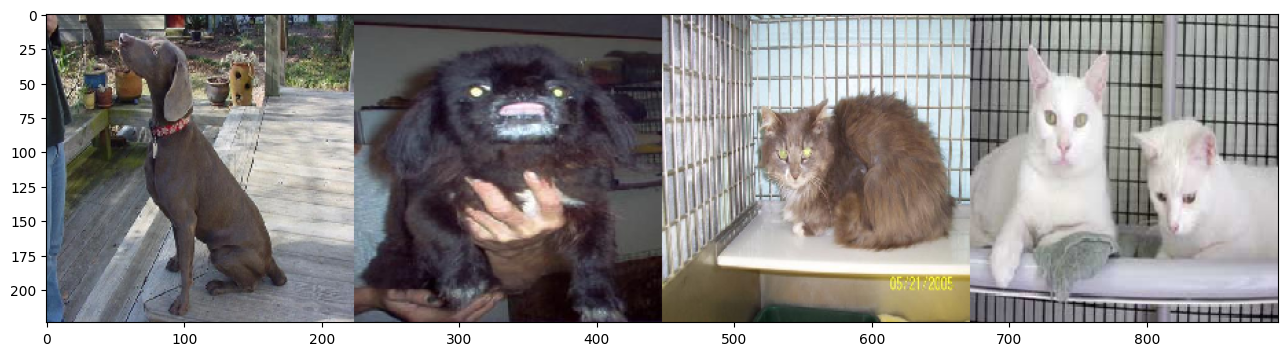

In [31]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(4)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## First training a neural net from scratch
Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a dropout after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our optimizer algorithm will be AdaDelta. Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run model.summary() to get a snapshot of its layers.

In [37]:
# build the network
model = Sequential()
print("Input dimensions: ",X_train.shape[1:])

model.add(Input(shape=X_train.shape[1:]))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

With the code above we've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later.

In [ ]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_val, y_val))